In [9]:
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [10]:
# Import data
df_train = pd.read_csv('/kaggle/input/scaled-lamah-dataset-7030-traintest-ratio/scaled_train.csv', sep=';')
df_test = pd.read_csv('/kaggle/input/scaled-lamah-dataset-7030-traintest-ratio/scaled_test.csv', sep=';')

In [23]:
# Use standard random forest classifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score



# Create the model with 100 trees
model = RandomForestRegressor(n_estimators=100,
                               bootstrap = True,
                               max_features = 'sqrt',
                             random_state = 42)

# Fit on training data
model.fit(df_train.drop('prec', axis=1), df_train['prec'])

# Actual class predictions
rf_predictions = model.predict(df_test.drop('prec', axis=1))

Mean squared error: 0.81
Variance score: 0.35


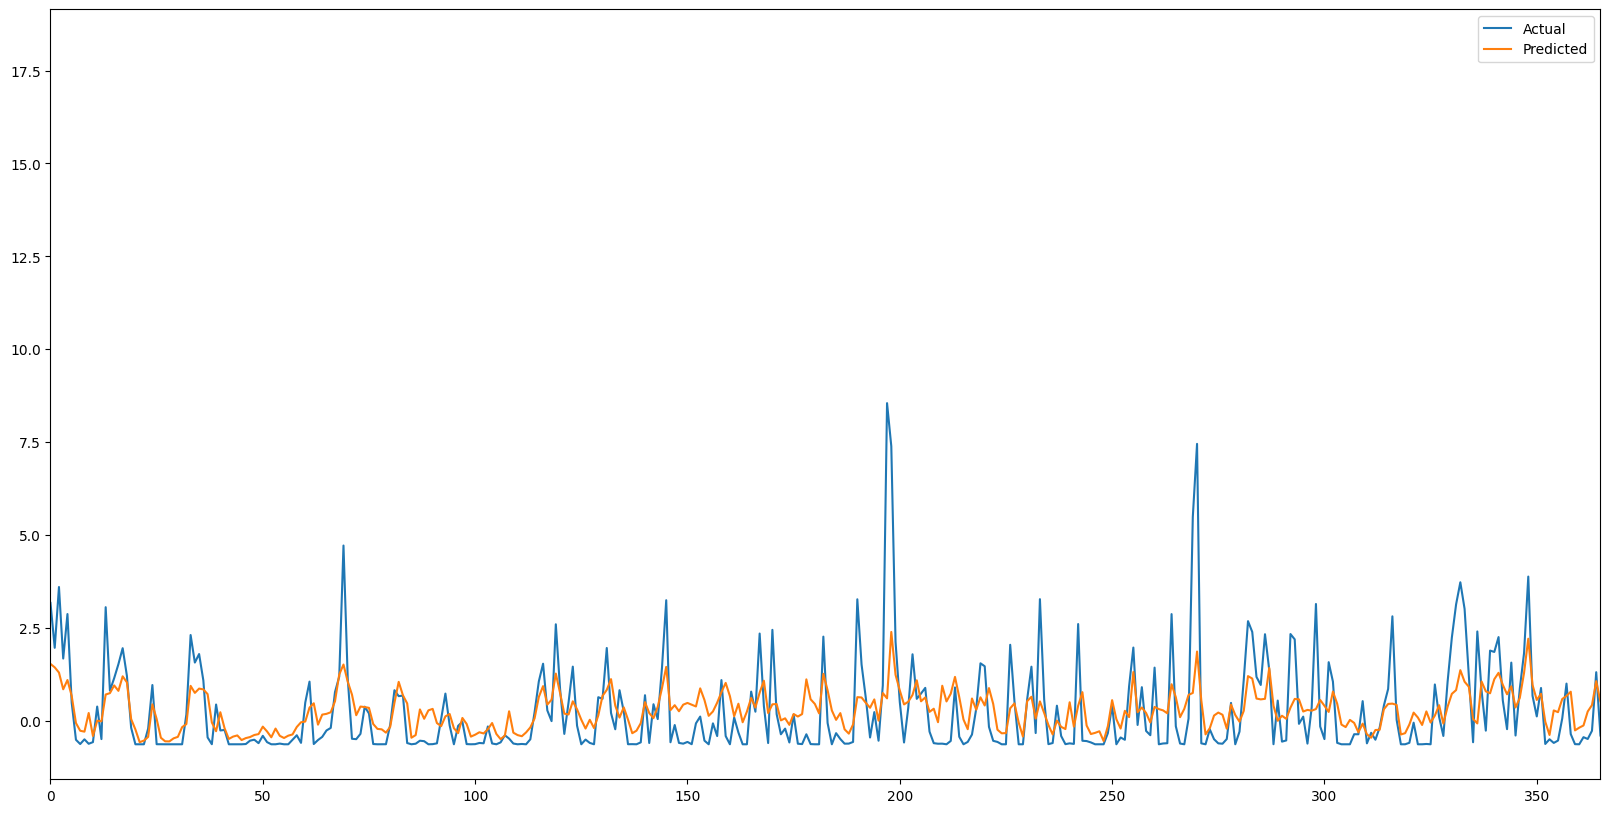

In [24]:
# The root mean squared error (RMSE), parameter squared=False gives the RMSE
print("Mean squared error: %.2f"
      % mean_squared_error(df_test['prec'], rf_predictions, squared=False))

# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(df_test['prec'], rf_predictions))

# Plot predictions in time series plot compared to actual values
plt.figure(figsize=(20, 10))
plt.plot(df_test['prec'], label='Actual')
plt.plot(rf_predictions, label='Predicted')

# Only plot the first year
plt.xlim(0, 365)

plt.legend()

## Hyperparameter optimization

In [13]:
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(model.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


Following parameters will be adjusted:

n_estimators = number of trees in the foreset\
max_features = max number of features considered for splitting a node\
max_depth = max number of levels in each decision tree \
min_samples_split = min number of data points placed in a node before the node is split\
min_samples_leaf = min number of data points allowed in a leaf node

In [14]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 20, stop = 200, num = 10)]
# Number of features to consider at every split
max_features = [1.0, 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
               }
pprint(random_grid)

{'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': [1.0, 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]}


In [15]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, scoring="neg_root_mean_squared_error",n_iter = 7,cv = 2, verbose=2, random_state=42)
# Fit the random search model
rf_random.fit(df_train.drop('prec', axis=1), df_train['prec'])

Fitting 2 folds for each of 7 candidates, totalling 14 fits
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=20; total time=  45.5s
[CV] END max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=20; total time=  46.2s
[CV] END max_depth=80, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=19.7min
[CV] END max_depth=80, max_features=1.0, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=19.4min
[CV] END max_depth=70, max_features=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=20; total time= 3.7min
[CV] END max_depth=70, max_features=1.0, min_samples_leaf=2, min_samples_split=10, n_estimators=20; total time= 3.7min
[CV] END max_depth=70, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=120; total time=24.2min
[CV] END max_depth=70, max_features=1.0, min_samples_leaf=1, min_samples_split=5, n_estimators=120; total

RandomizedSearchCV(cv=2, estimator=RandomForestRegressor(), n_iter=7,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': [1.0, 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [20, 40, 60, 80, 100,
                                                         120, 140, 160, 180,
                                                         200]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=2)

In [16]:
rf_random.best_params_

{'n_estimators': 180,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 70}

In [17]:
rf_random.scorer_

make_scorer(mean_squared_error, greater_is_better=False, squared=False)

# Step 2 - Feature importance

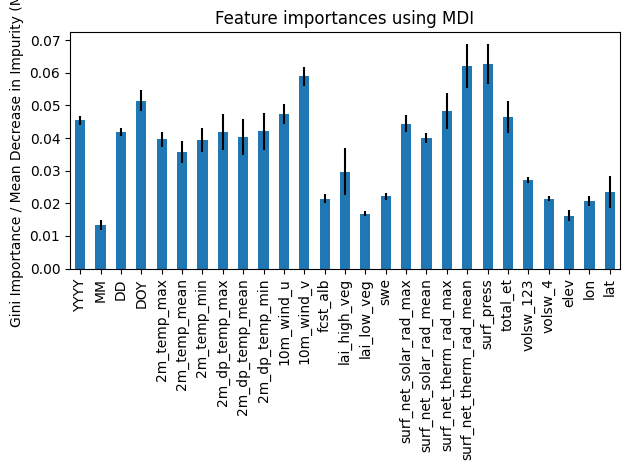

In [18]:
# Get numerical feature importances
importances = rf_random.feature_importances_

# Plot feature importances
std = np.std([tree.feature_importances_ for tree in rf_random.estimators_], axis=0)

forest_importances = pd.Series(importances, index=df_train.drop('prec', axis=1).columns)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Gini Importance / Mean Decrease in Impurity (MDI)")
fig.tight_layout()

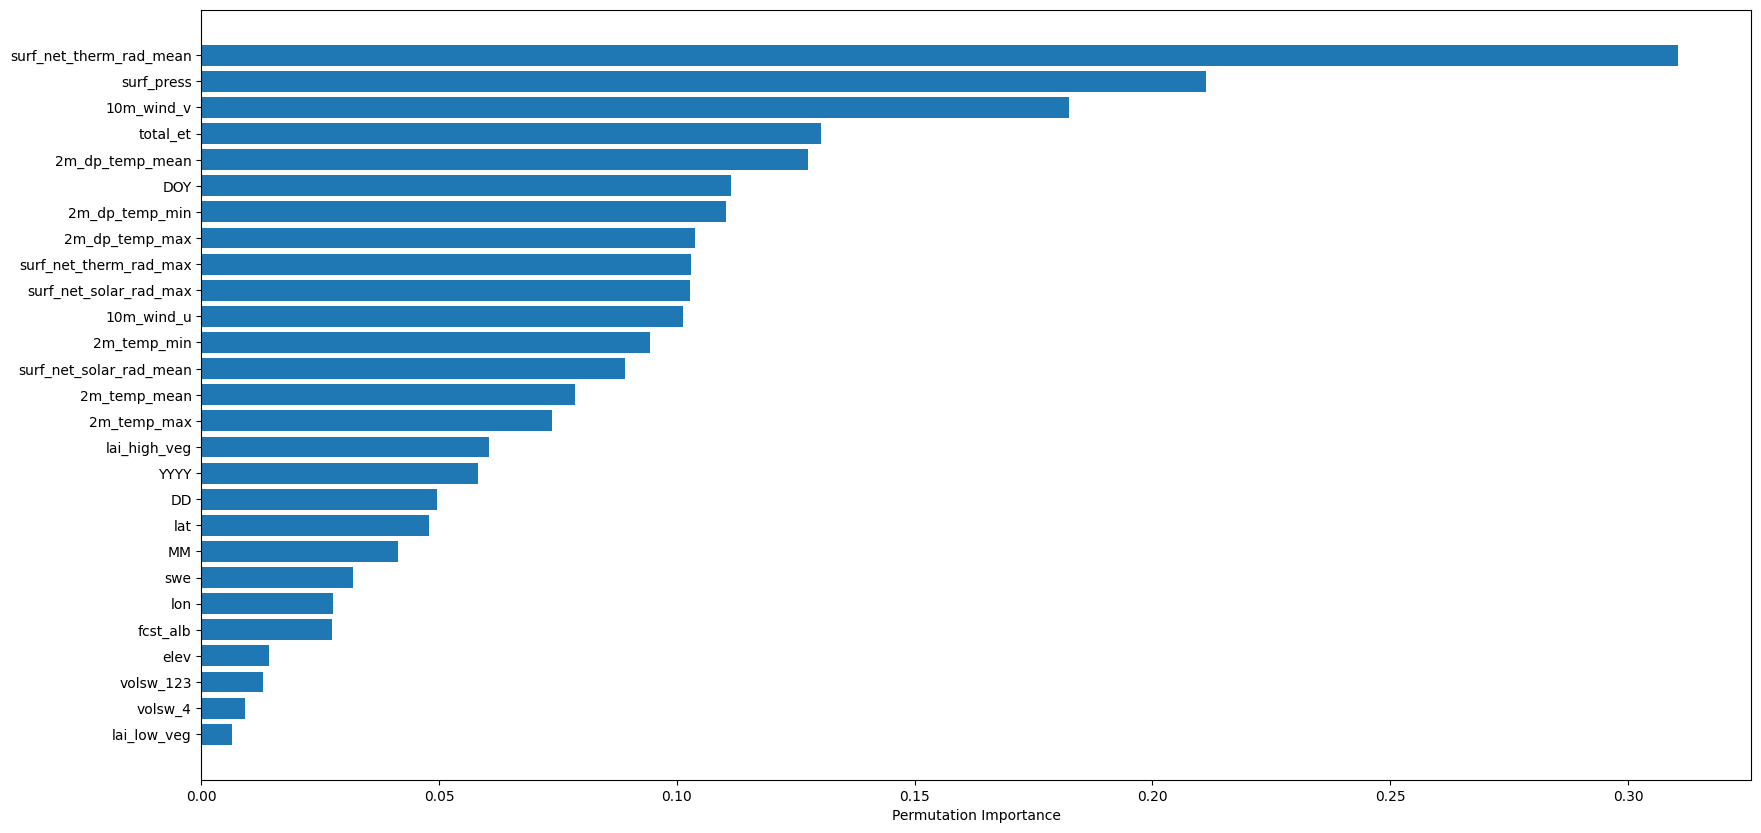

In [19]:
from sklearn.inspection import permutation_importance


perm_importance = permutation_importance(rf_random, df_test.drop('prec', axis=1), df_test['prec'], n_repeats=2, random_state=42)

# Sort the indices of the permutation importance values
sorted_idx = perm_importance.importances_mean.argsort()

# Plot the permutation importance values
plt.figure(figsize=(20, 10))
plt.barh(df_test.drop('prec', axis=1).columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

# Add the column names to the plot
plt.yticks(ticks=range(len(df_test.drop('prec', axis=1).columns)), labels=df_test.drop('prec', axis=1).columns[sorted_idx])
plt.show()


# Export analysing data


In [20]:
# Create empty dataframe
df = pd.DataFrame()

# Add column names
df['feature_names'] = df_train.drop('prec', axis=1).columns[sorted_idx]

# Add feature names and importance to dataframe
df['feature_importance_values'] = perm_importance.importances_mean[sorted_idx]

# Add priority of column names
df['original_order'] = perm_importance.importances_mean.argsort()

# Add root mean squared error
df['rmse'] = mean_squared_error(df_test['prec'], rf_predictions, squared=False)

df.head()

,feature_names,feature_importance_values,original_order,rmse
0,lai_low_veg,0.006503,14,0.805975
1,volsw_4,0.009152,23,0.805975
2,volsw_123,0.012836,22,0.805975
3,elev,0.014127,24,0.805975
4,fcst_alb,0.027531,12,0.805975


In [22]:
# Actual class predictions with random search model
rf_predictions_random = rf_random.predict(df_test.drop('prec', axis=1))

# The root mean squared error (RMSE), parameter squared=False gives the RMSE
print("Mean squared error: %.2f"
      % mean_squared_error(df_test['prec'], rf_predictions_random, squared=False))

Mean squared error: 0.82


In [21]:
# Export to csv file
df.to_csv('./random_forest_model_feature_importance.csv', sep=';', index=False)